# Importing Libraries

This might take a few seconds. If any library is missing, make sure to install it in your environment, using anaconda in for library installation is usually easier

In [1]:
import matplotlib
import math
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
%matplotlib notebook

ModuleNotFoundError: No module named 'cv2'

# 1. Image Warping

In this section, <b>you are not allowed to use any OpenCV functions.</b> OpenCV comes in the next section

## 1.1 Projective Transformations


in this section you will be creating a function `warpPerspective(img,M,(cols,rows))`. 
The function performs a projective transformation on an image and returns a new image variable
    
    This function has the following arguments:
        img: original image variable. This can be a black and white or a color image
        M: a 3x3 projective transformation matrix
        cols: the columns of the output image
        rows: the rows of the output matrix        

The function can transform a small image to a larger image. While doing so, the new image must not have any fringes or emply pixels, you can fill those pixels by taking the value of the nearest neigbouring pixel. The pixels outside of an image may be set to black for now. You may change the arguments of the function if you want to add additional features

In [82]:
def warpPerspective(img,M,dsize):
    rot_theeta = M.copy() # 3x3
    
    x = img.shape[0] # 157
    y = img.shape[1] # 114
    
#     [0,156,0,156]
#     [0,0,113,113]
#     [1,1,1,1]

    corners = np.array([ #top left, bottom left, top right, bottom right, # 114 columns & 157 rows
        [0,x-1,0,x-1], 
        [0,0,y-1,y-1], 
        [1,1,1,1]
    ])

    rotated = np.matmul(rot_theeta, corners) #3x3 by 3x4
    
    min_x = min_row(rotated,0)
    min_y = min_row(rotated,1)
    
    if min_x < 0 or min_y < 0:
        
        trans = np.array([
            [1,0,-(min_x)],
            [0,1,-(min_y)],
            [0,0,1]
        ])

        matrix = np.matmul(trans, rotated) #3x3 by 3x4

        trans_inv = np.linalg.inv(trans) # 3x3
        rot_inv =  np.linalg.inv(rot_theeta) # 3x3
        inv = np.matmul(rot_inv, trans_inv) # 3x3
    else:
    inv =  np.linalg.inv(rot_theeta) # 3x3
    
    col = dsize[0]
    row = dsize[1]
    
    
    return inv

In [88]:
def min_row(m_array, row_no):
    the_row = m_array[row_no:]
    min = m_array[row_no,0]
    for i in range(m_array.shape[1]):
        if m_array[row_no,i]<=min:
            min = m_array[row_no,i]
    return min
def max_row(m_array, row_no):
    the_row = m_array[row_no:]
    max = m_array[row_no,0]
    for i in range(4):
        if m_array[row_no,i]>max:
            max = m_array[row_no,i]
    return max

## 1.1 Task 1.1


In this test case, we will be rotating a subsection of an image of a cat. We will convert `cat.jpg` to `cat_sol0_1.jpg`


__cat.jpg__
<img src="part1/task1/cat.jpg" alt="cat.jpg" title="cat.jpg" />

__cat_sol0_1.jpg__
<img src="part1/task1/cat_sol0_1.jpg" alt="cat_sol0_1.jpg" title="cat_sol0_1.jpg" />

We can utilize your newly made function for that with the following steps

1. read the file `part1/task1/cat.jpg`
2. crop it to the portion that shows just the head
3. input it to your function with your projective matrix
4. display the output
5. you can adjust the row and col values such that the entirety of the output image is shown
    
the output should look similar to `part1/task1/cat_sol0_1.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those

<IPython.core.display.Javascript object>


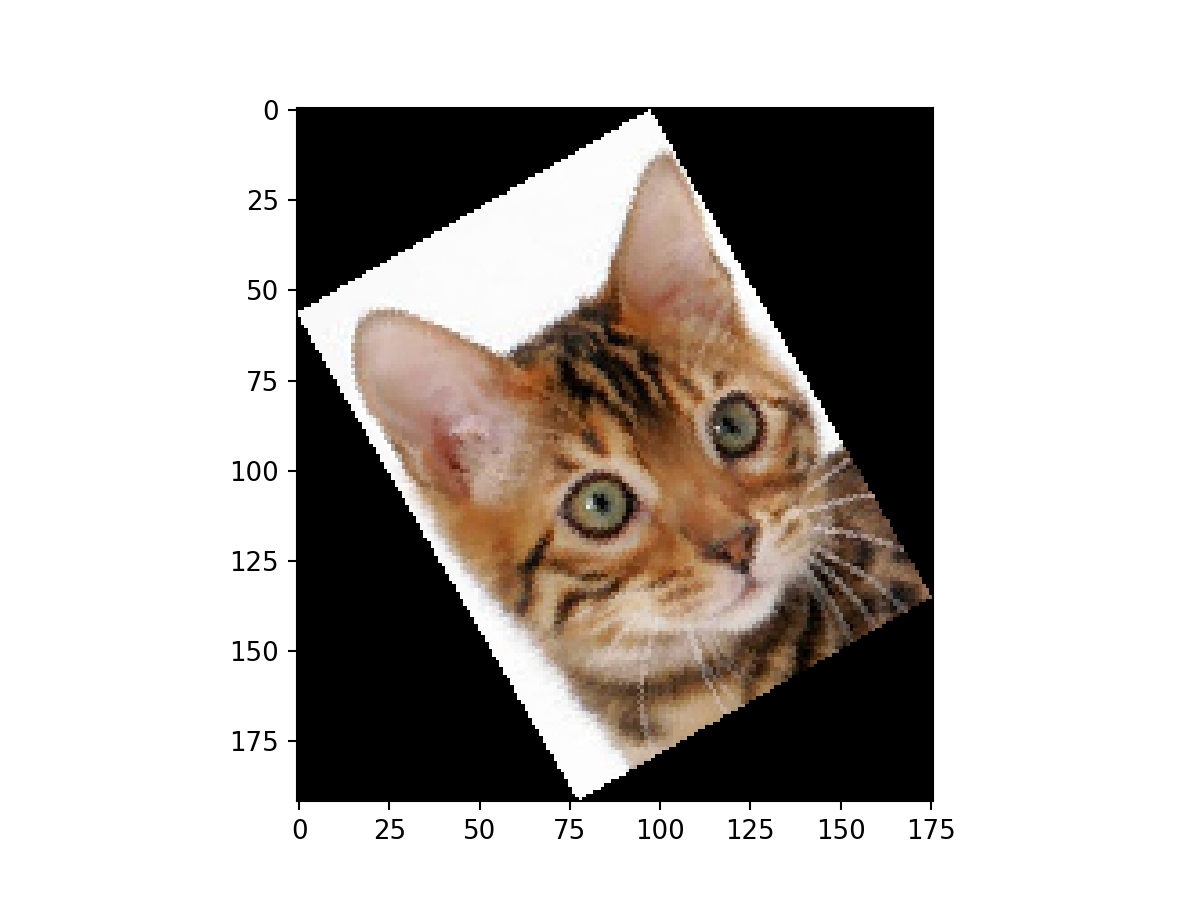

In [63]:
cat = np.array(mpimg.imread('part1/task1/cat.jpg'))
cat.setflags(write=1)


cat_crop = cat[0:157,85:199] # [row, columns]

M = np.array([
        [np.cos(np.radians(30)), np.sin(np.radians(-30)), 0],
        [np.sin(np.radians(30)), np.cos(np.radians(30)), 0],
        [0, 0, 1]
    ])

cols =  cat_crop.shape[1] - 1 # 113
rows =  cat_crop.shape[0] - 1 # 156

corners = np.array([ #top left, bottom left, top right, bottom right, # 114 columns & 157 rows
        [0,rows,0,rows], 
        [0,0,cols,cols], 
        [1,1,1,1]
    ])

rotated = np.matmul(M, corners) #3x3 by 3x4

max_x = max_row(rotated,0)
max_y = max_row(rotated,1)
min_x = min_row(rotated,0)
min_y = min_row(rotated,1)
range_x = np.round(max_x - min_x)
range_y = np.round(max_y - min_y)
range_x = int(range_x) # optimal columns
range_y = int(range_y) # optimal rows

inverse = warpPerspective(cat_crop,M,(cols,rows))

final = np.zeros((range_x,range_y,3)).astype(np.int)

for i in range(range_x):
    for j in range(range_y):
        cordinate = np.array([i,j,1])
        pt = np.matmul(inverse,cordinate) # 3x3 by 3x1
        r_pt = (np.round(pt)) # 3x1 a cordinate [?,?,?] [row, column, 1]
        if r_pt[0]<0 or r_pt[0]>= rows:
            final[i][j]= np.array([0,0,0]) # In the 3d array the 3rd diminsion is matrix [r,g,b]
        elif r_pt[1]<0 or r_pt[1]>= cols:
            final[i][j]= np.array([0,0,0])
        else:
            final[i][j]=cat_crop[int(r_pt[0]),int(r_pt[1])]

figure(dpi = 150)
plt.imshow(final)
plt.show()

## 1.2 Bilinear Interpolation

At this point, you can predict that creating a large image from small image will not give us the best results, ie results with a lot of pixelations. There are multiple ways to handle this, the method we will be utilizing in this assignment is `Bilinear Interpulation`. With this we can achieve a result with less pixelation, as shown in `cat_sol1.jpg`


__cat_sol1.jpg__
<img src="part1/task1/cat_sol1.jpg" alt="cat_sol1.jpg" title="cat_sol1.jpg" />

## 1.2 Task 1.2


For this, we can augment your function `warpPerspective(img,M,(cols,rows))`.

1. Where you previously took the nearest neigbor to fill missing pixels, use the `Bilinear Interpulation` algorithm. 
2. input cols and rows values as 2000 and 2160
3. use the same projective matrix
4. display the output
    
the output should look similar to `part1/task1/cat_sol1.jpg`.

<IPython.core.display.Javascript object>


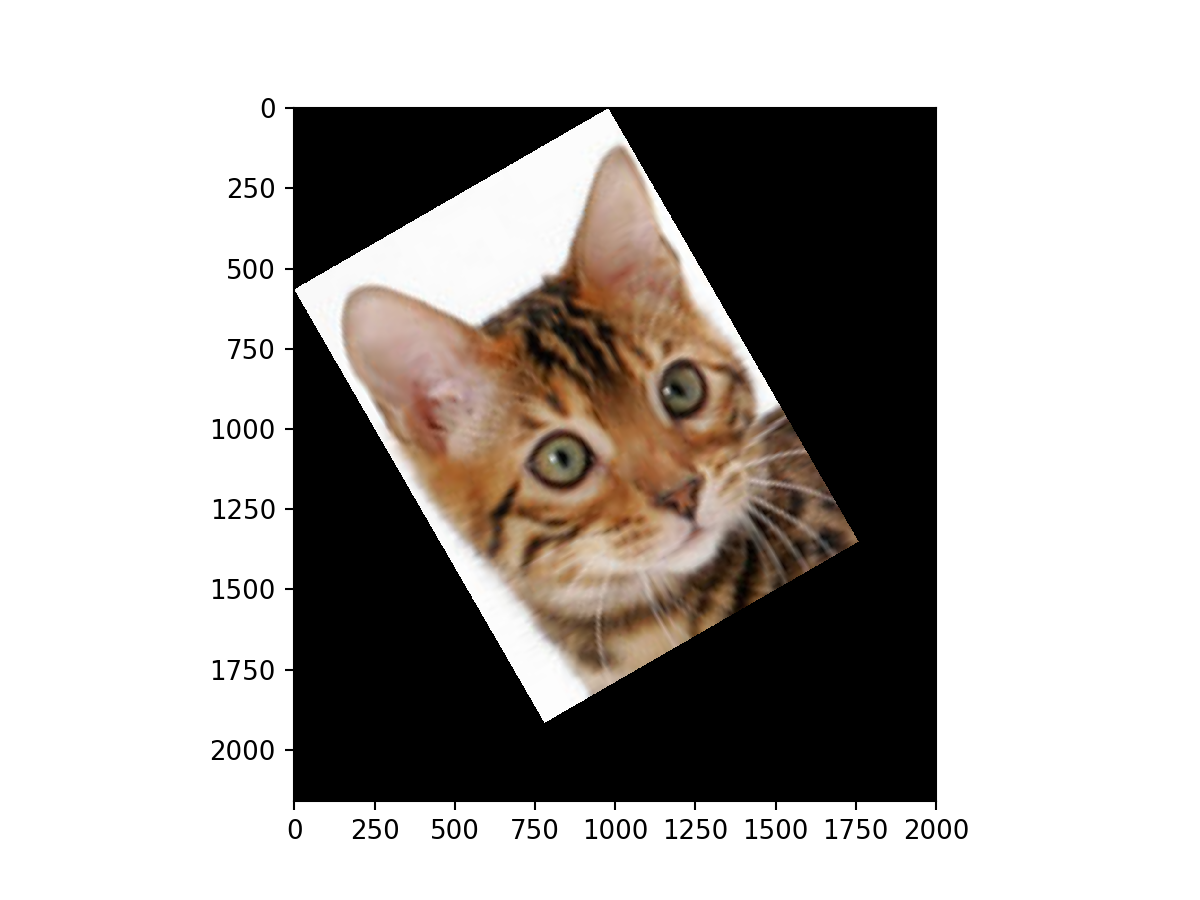

In [294]:
cat = np.array(mpimg.imread('part1/task1/cat.jpg'))
cat.setflags(write=1)


cat_crop = cat[0:157,85:199] # [row, columns]
cat_rows, cat_cols, _ = cat_crop.shape

scale = np.array([
    [10, 0, 0],
    [0, 10, 0],
    [0, 0, 1]
])

rot_mat = np.array([
        [np.cos(np.radians(30)), np.sin(np.radians(-30)), 0],
        [np.sin(np.radians(30)), np.cos(np.radians(30)), 0],
        [0, 0, 1]
    ])

M = np.matmul(rot_mat,scale)
cat_crop.shape

cols = 2000
rows = 2160

inverse = warpPerspective(cat_crop,M,(cols,rows))

black = np.zeros((rows,cols,3)).astype(np.int)
for i in range(rows):
    for j in range(cols):
        cordinate = np.array([i,j,1])
        pt = np.matmul(inverse,cordinate) # 3x3 by 3x1
        in_row, in_col = pt[0], pt[1]
        
        if (in_row > 0 and in_col > 0 and in_row < cat_rows-1 and in_col < cat_cols-1):
            
            t_l = (int(in_row),int(in_col))
            t_r = (int(in_row),int(in_col)+1)
            b_l = (int(in_row)+1,int(in_col))
            b_r = (int(in_row)+1,int(in_col)+1)

            intrpl_top = (in_col - t_l[1])*cat_crop[t_r[0],t_r[1]] + (t_r[1]- in_col )*cat_crop[t_l[0],t_l[1]]
            intrpl_bot = (in_col- b_l[1])*cat_crop[b_r[0],b_r[1]] + (b_r[1]- in_col)*cat_crop[b_l[0],b_l[1]]

            intrpl_side = (in_row - t_l[0])*intrpl_bot + (b_l[0]- in_row)*intrpl_top
            black[i][j] = intrpl_side
            
figure(dpi = 150)
plt.imshow(black)
plt.show()

## 1.3 Image Blending


In this section we will be blending two images to create a third image. This process is important in applications such as VR or ,as Sir's favoute example, showing adverts in cricket fields. 

For this section, it is important to understand alpha values. Alpha values range between 0.0 and 1.0, and determine the transparency of a pixel. These are common in png files where they are stored alongside rgb as rgba. 

## 1.3 Task 1.3

You must manipulate your `warpPerspective(img,M,(cols,rows))` function so that it returns values in the form of rgba. You can do this with the following steps: 

1. if the image has values in 8bit integers, convert your 0 - 255 color integer value range to 0.0 - 1.0 float. It might be easier to create a seperate function that converts rgb to rgba with alpha values set to 1.0
2. append a forth pixel value for the alpha
3. where you you were previously setting the background to be black, also set the alpha to 0.0
    
the output from the prvious test should look similar to `part1/task1/cat_sol2.png`. you can explore the png file structure to get a better idea of the output. 


__cat_sol2.png__
<img src="part1/task1/cat_sol2.png" alt="cat_sol2.png" title="cat_sol2.png" />

<IPython.core.display.Javascript object>


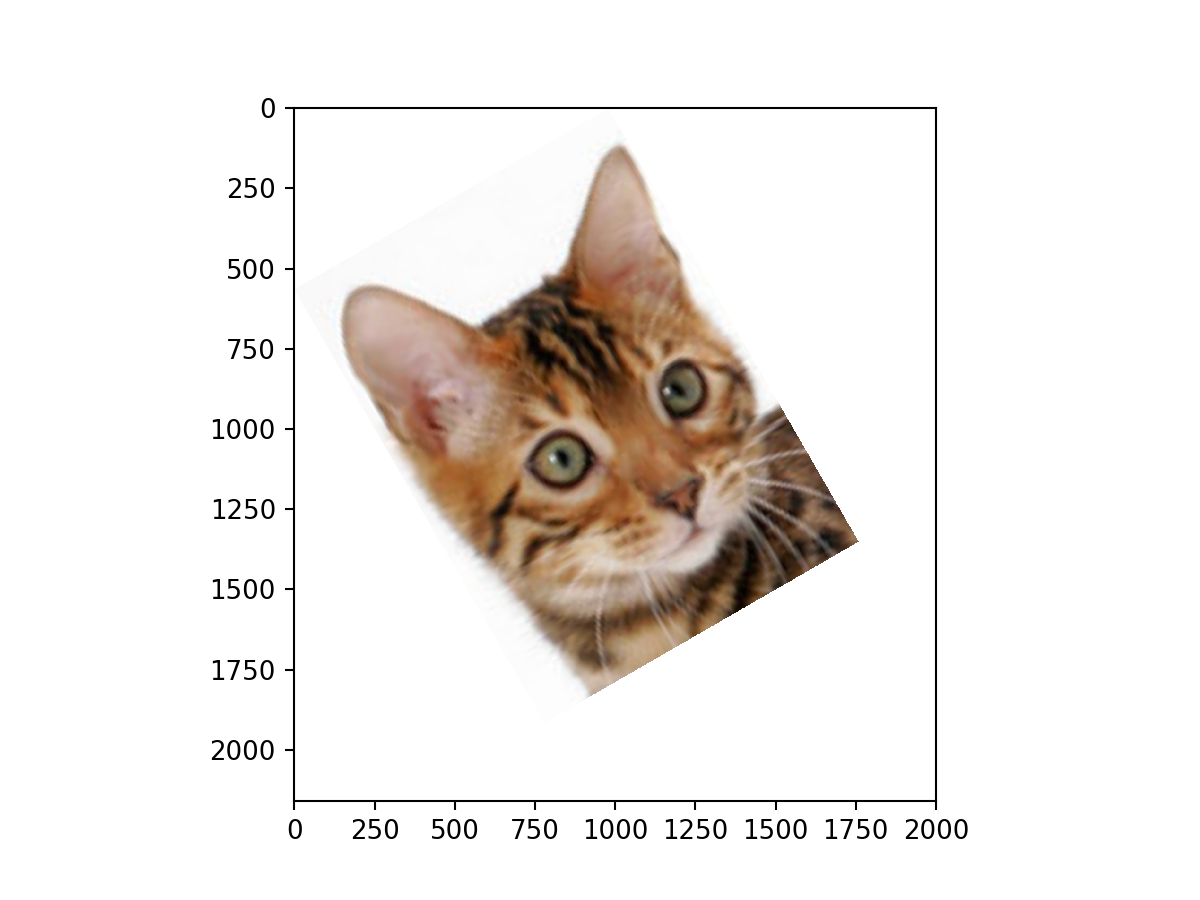

In [48]:
cat = np.array(mpimg.imread('part1/task1/cat.jpg'))
cat.setflags(write=1)


cat_crop = cat[0:157,85:199] # [row, columns]
cat_rows, cat_cols, _ = cat_crop.shape

scale = np.array([
    [10, 0, 0],
    [0, 10, 0],
    [0, 0, 1]
])

rot_mat = np.array([
        [np.cos(np.radians(30)), np.sin(np.radians(-30)), 0],
        [np.sin(np.radians(30)), np.cos(np.radians(30)), 0],
        [0, 0, 1]
    ])

M = np.matmul(rot_mat,scale)

cols = 2000
rows = 2160

inverse = warpPerspective(cat_crop,M,(cols,rows))

def convert_rgba(pixel):
    return np.array([pixel[0]/255.0,pixel[1]/255.0,pixel[2]/255.0,1.0]) 

black = np.zeros((rows,cols,4))
for i in range(rows):
    for j in range(cols):
        cordinate = np.array([i,j,1])
        pt = np.matmul(inverse,cordinate) # 3x3 by 3x1
        in_row, in_col = pt[0], pt[1] # Values on the image in cat crop
        # Cant bilinear interpolate the edges so compare with boundary conditions 
        if (in_row > 0 and in_col > 0 and in_row < cat_rows-1 and in_col < cat_cols-1): # Handling the values mapped on the edges
            
            t_l = (int(in_row),int(in_col))
            t_r = (int(in_row),int(in_col)+1)
            b_l = (int(in_row)+1,int(in_col))
            b_r = (int(in_row)+1,int(in_col)+1)
            # cat_crop[_,_] corresponds to a pixel. This basically accessing a matrix ele
            intrpl_top = (in_col - t_l[1])*cat_crop[t_r[0],t_r[1]] + (t_r[1]- in_col )*cat_crop[t_l[0],t_l[1]]
            intrpl_bot = (in_col- b_l[1])*cat_crop[b_r[0],b_r[1]] + (b_r[1]- in_col)*cat_crop[b_l[0],b_l[1]]

            intrpl_side = (in_row - t_l[0])*intrpl_bot + (b_l[0]- in_row)*intrpl_top
            black[i][j] = convert_rgba(intrpl_side)
            
mpimg.imsave('cat.png',black) # if saving rgb files, remove cmap 
            
figure(dpi = 150)
plt.imshow(black)
plt.show()

## 1.2.1 Task2

In this test we will be adding an image of to an empty billboard. The image that we will be adding is, you guessed it, a cat.

you are provided with a billboard file at `part1/task2/billboard.jpg` and an image of a cat at `part1/task2/cat.jpg`

your job is to combine them to get `part1/task2/billboard_sol.png`

__billboard.jpg__
<img src="part1/task2/billboard.jpg" alt="billboard.jpg" title="billboard.jpg" />

__cat.jpg__
<img src="part1/task2/cat.jpg" alt="cat.jpg" title="cat.jpg" />

__billboard_sol.png__
<img src="part1/task2/billboard_sol.png" alt="billboard_sol.png" title="billboard_sol.png" />

You can do this by

1. manipulating the image of the cat using the `warpPerspective(img,M,(cols,rows))` function to look like the billboard. _notice that the cat is mirrored_
2. replace values in the billboard image, at the location of the billboard, to the values of your new cat image. _remember to take alpha values in consideration_

<IPython.core.display.Javascript object>


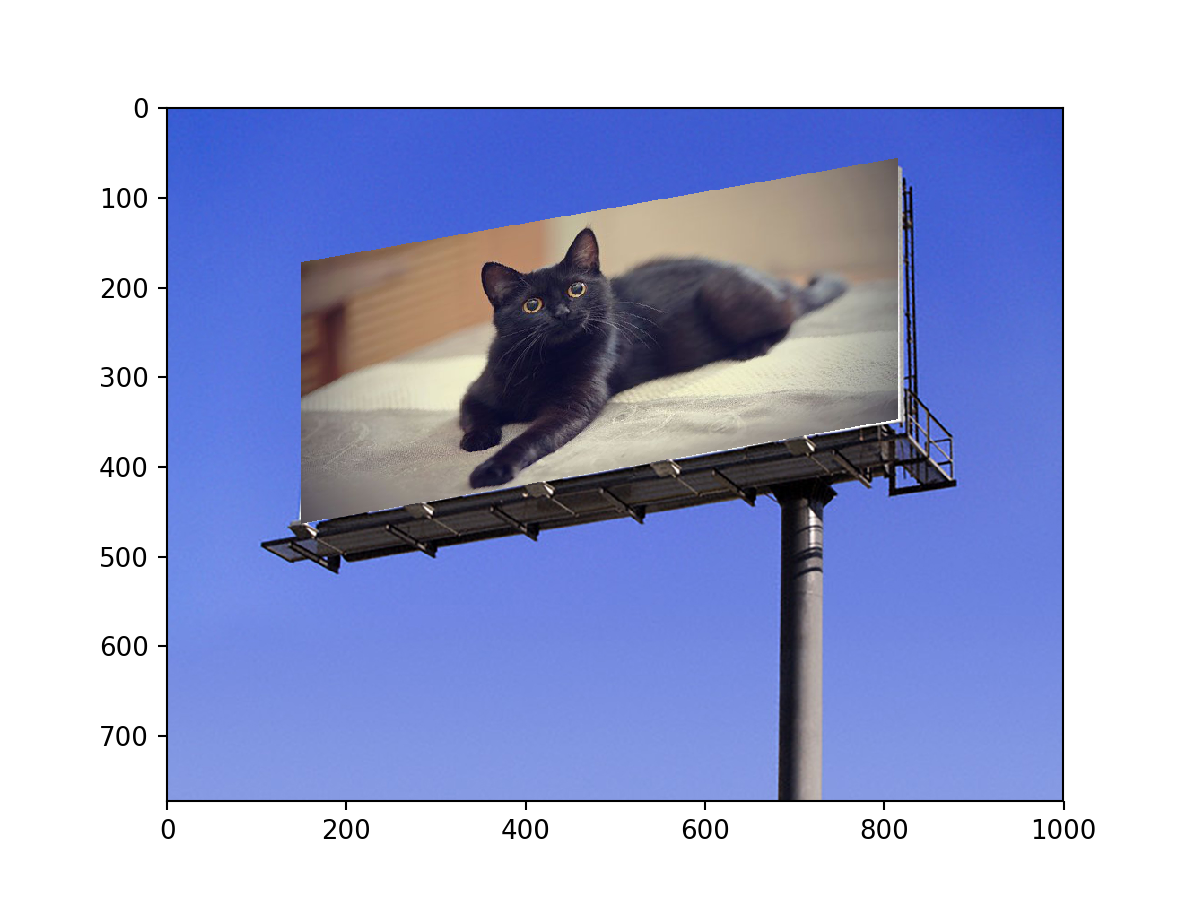

In [157]:
#TODO
cat_2 = np.array(mpimg.imread('part1/task2/cat.jpg'))
cat_2.setflags(write=1)
billboard = np.array(mpimg.imread('part1/task2/billboard.jpg'))
billboard.setflags(write=1) 

reflect = np.array([
    [1,0,0],
    [0,-1,0],
    [0,0,1]
])

inv = warpPerspective(cat_2,reflect,(cols,rows))

shear = np.array([
    [1,-0.21,0],
    [0,1,0],
    [0,0,1]
])

scale = np.array([
    [0.85,0,0],
    [0,1.02,0],
    [0,0,1]
])

trans2 = np.array([
    [1,0,172],
    [0,1,149],
    [0,0,1]
])

trans2_inv = np.linalg.inv(trans2)
scale_inv = np.linalg.inv(scale)
shear_inv = np.linalg.inv(shear)

inverse = np.matmul(scale_inv,trans2_inv)
inverse = np.matmul(shear_inv,inverse)
inverse = np.matmul(inv,inverse)



board = np.zeros((billboard.shape[0],billboard.shape[1],4))

for i in range(billboard.shape[0]):
    for j in range(billboard.shape[1]):
        board[i][j] = convert_rgba(billboard[i][j])
    

        
for i in range(board.shape[0]):
    for j in range(board.shape[1]):
        cordinate = np.array([i,j,1])
        pt = np.matmul(inverse,cordinate) # 3x3 by 3x1
        r_pt = (np.round(pt)) # 3x1 a cordinate [?,?,?] [row, column, 1]
        if r_pt[0]<0 or r_pt[0]> cat_2.shape[0]-1:
            board[i][j]= board[i][j] # In the 3d array the 3rd diminsion is matrix [r,g,b]
        elif r_pt[1]<0 or r_pt[1]> cat_2.shape[1]-1:
            board[i][j]= board[i][j]
        else:
            board[i][j]=convert_rgba(cat_2[int(r_pt[0]),int(r_pt[1])])
            
figure(dpi = 150)
plt.imshow(board)
plt.show()

## 1.4 Alpha masks & Grouping
From the previous task, hopefully you realized the importance of alpha values. In certain situations, when we want to isolate a subject in an image, aplha masks are provided to us. Alpha masks describe the transparency of an image. These masks can be in any format ranging from jpg,png,bmp,gif,etc in our example we will be using jpg.

In this section we will be using alpha masks to group two images together.

## 1.2.1 Task3

Suppose we want to create an image of Sir murtaza petting a dog, cuz ya know, he's nice like that. 

We can combile two images I found on the web and the techniques we learned in our previous problems. 

We have two images `part1/task3/pupper.jpg` and `part1/task3/dr_murtaza.jpg` and we want to create `part1/task3/dr_murtaza_sol_petting.png`

__pupper.jpg__ _(study the test pupper)_
<img src="part1/task3/pupper.jpg" alt="pupper.jpg" title="pupper.jpg" />

__dr_murtaza.jpg__ _(no i did not stalk him)_
<img src="part1/task3/dr_murtaza.jpg" alt="dr_murtaza.jpg" title="dr_murtaza.jpg" />

__dr_murtaza_sol_petting.png__
<img src="part1/task3/dr_murtaza_sol_petting.png" alt="dr_murtaza_sol_petting.png" title="dr_murtaza_sol_petting.png" />

## 1.2.1 Task3.1 Alpha masks

In this section you will be using alpha masks to isolate sections of our image. 

for `part1/task3/pupper.jpg` you are provided with the mask `part1/task3/pupper_mask.jpg` use it to isolate the dog from image, as shown in `part1/task3/pupper_sol0_1.png`. The whiter the pixel value in a mask, the more its alpha value

__pupper.jpg__
<img src="part1/task3/pupper.jpg" alt="pupper.jpg" title="pupper.jpg" />

__pupper_mask.jpg__
<img src="part1/task3/pupper_mask.jpg" alt="pupper_mask.jpg" title="pupper_mask.jpg" />

__pupper_sol0_1.png__
<img src="part1/task3/pupper_sol0_1.png" alt="pupper_sol0_1.png" title="pupper_sol0_1.png" />

<IPython.core.display.Javascript object>


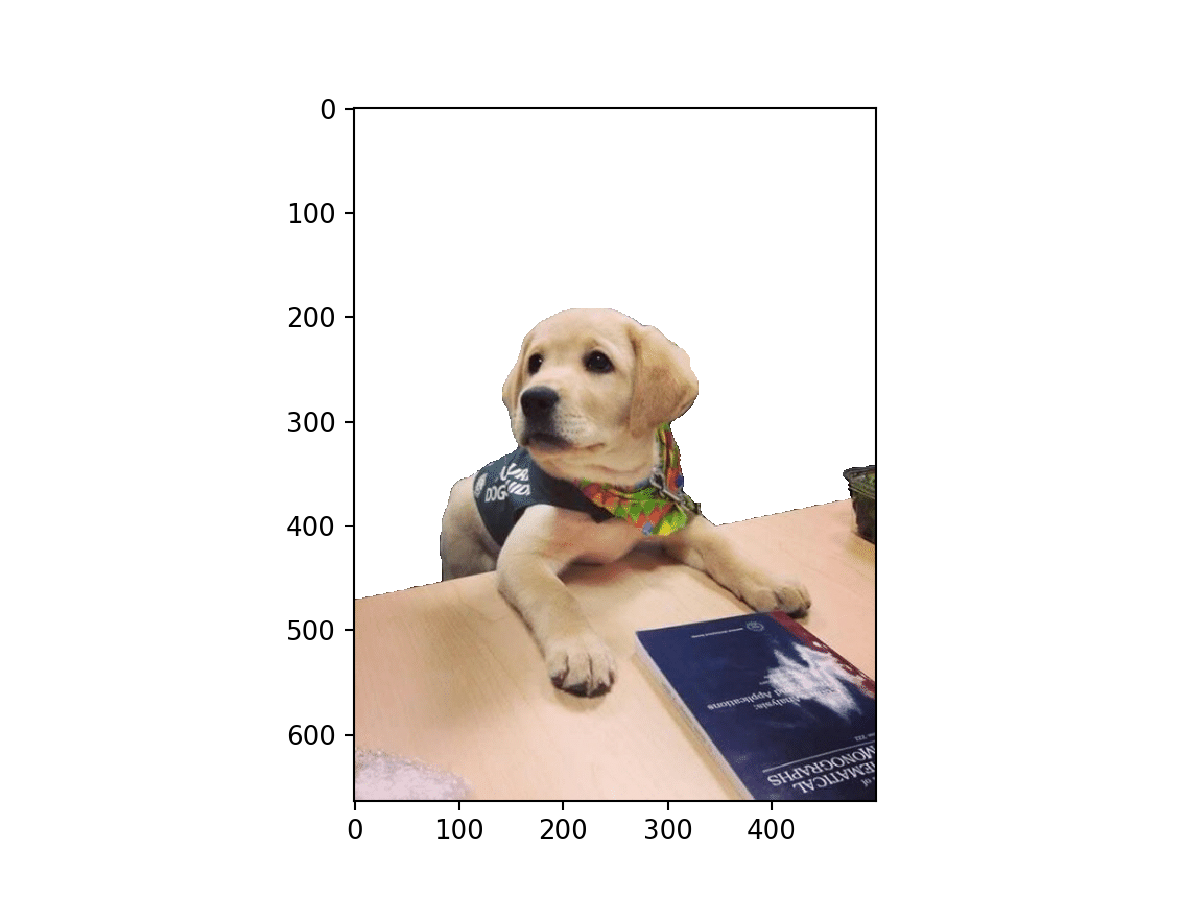

In [288]:
#TODO

pupper = np.array(mpimg.imread('part1/task3/pupper.jpg'))
pupper.setflags(write=1) 

pupper_mask = np.array(mpimg.imread('part1/task3/pupper_mask.jpg'))
pupper_mask.setflags(write=1) 

dog = np.zeros((pupper.shape[0],pupper.shape[1],4))

for i in range(pupper_mask.shape[0]):
    for j in range(pupper_mask.shape[1]):
        for k in range(3):
            if pupper_mask[i][j][k] < 100:
                continue
            else:
                dog[i][j][k] = pupper[i][j][k]/255
                dog[i][j][3] = 1.0
             
        
figure(dpi = 150)
plt.imshow(dog)
plt.show()        


Similar to the previous task, do the same for `part1/task3/dr_murtaza.jpg`, `part1/task3/dr_murtaza_mask.jpg` to get `part1/task3/dr_murtaza_sol0_1.png`

__dr_murtaza.jpg__
<img src="part1/task3/dr_murtaza.jpg" alt="dr_murtaza.jpg" title="dr_murtaza.jpg" />

__dr_murtaza_mask.jpg__
<img src="part1/task3/dr_murtaza_mask.jpg" alt="dr_murtaza_mask.jpg" title="dr_murtaza_mask.jpg" />

__dr_murtaza_sol0_1.png__
<img src="part1/task3/dr_murtaza_sol0_1.png" alt="dr_murtaza_sol0_1.png" title="dr_murtaza_sol0_1.png" />


<IPython.core.display.Javascript object>


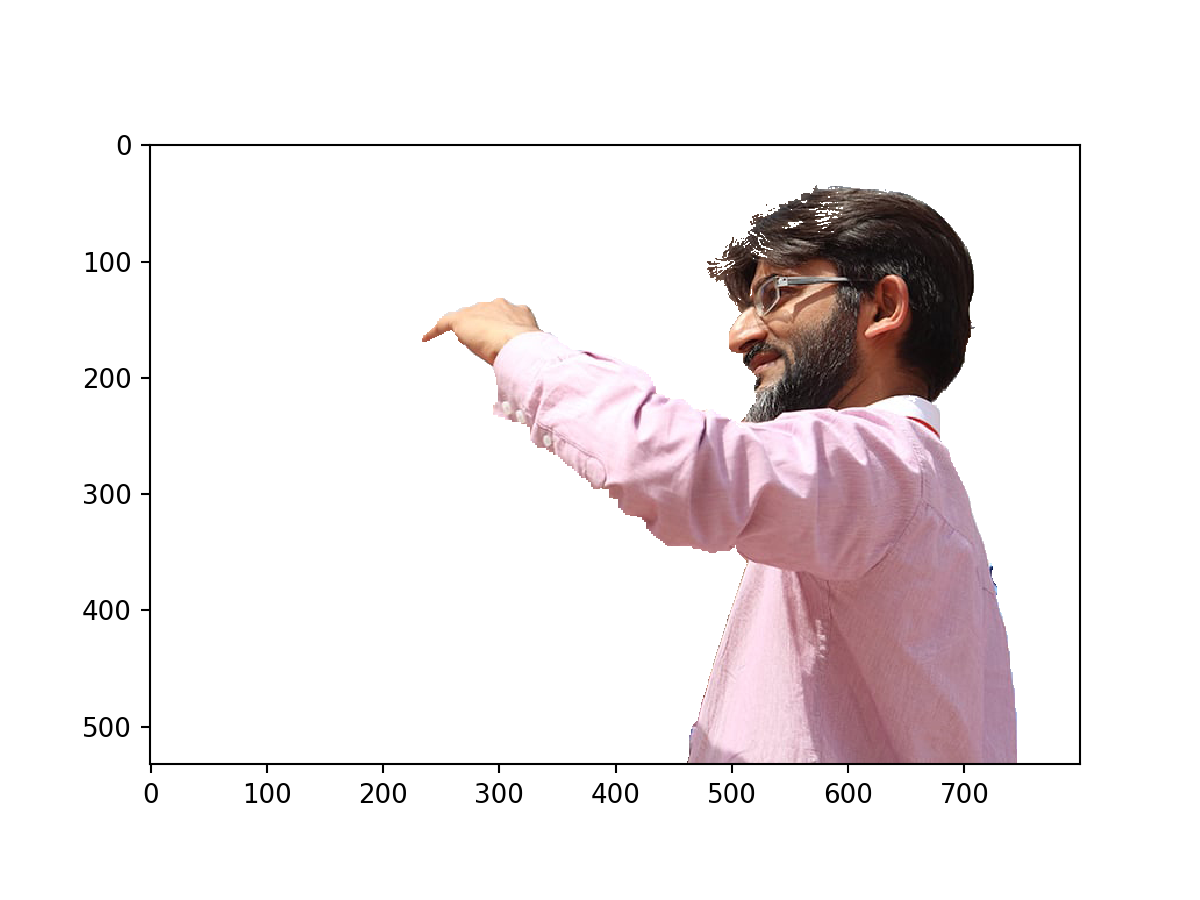

In [293]:
#TODO

dr_murtaza = np.array(mpimg.imread('part1/task3/dr_murtaza.jpg'))
dr_murtaza.setflags(write=1) 

mask = np.array(mpimg.imread('part1/task3/dr_murtaza_mask.jpg'))
mask.setflags(write=1) 

bro = np.zeros((dr_murtaza.shape[0],dr_murtaza.shape[1],4))

for i in range(dr_murtaza.shape[0]):
    for j in range(dr_murtaza.shape[1]):
        for k in range(3):
            if mask[i][j][k]< 100:
                continue
            else:
                bro[i][j][k] = dr_murtaza[i][j][k]/255
                bro[i][j][3] = 1.0
                
figure(dpi = 150)
plt.imshow(bro)
plt.show()     


## 1.2.1 Task3.2 Grouping

Now we can finally add the two to create our image

- add the masked pupper image file to the masked dr_murtaza image file. _remember to account for the latter's alpha values_
- tweek the location where you add the image, remember to create a case for when it goes out of bounds
- your solution should be similar to `part1/task3/dr_murtaza_sol_petting.png`

__dr_murtaza_sol_petting.png__
<img src="part1/task3/dr_murtaza_sol_petting.png" alt="dr_murtaza_sol_petting.png" title="dr_murtaza_sol_petting.png" />

<IPython.core.display.Javascript object>


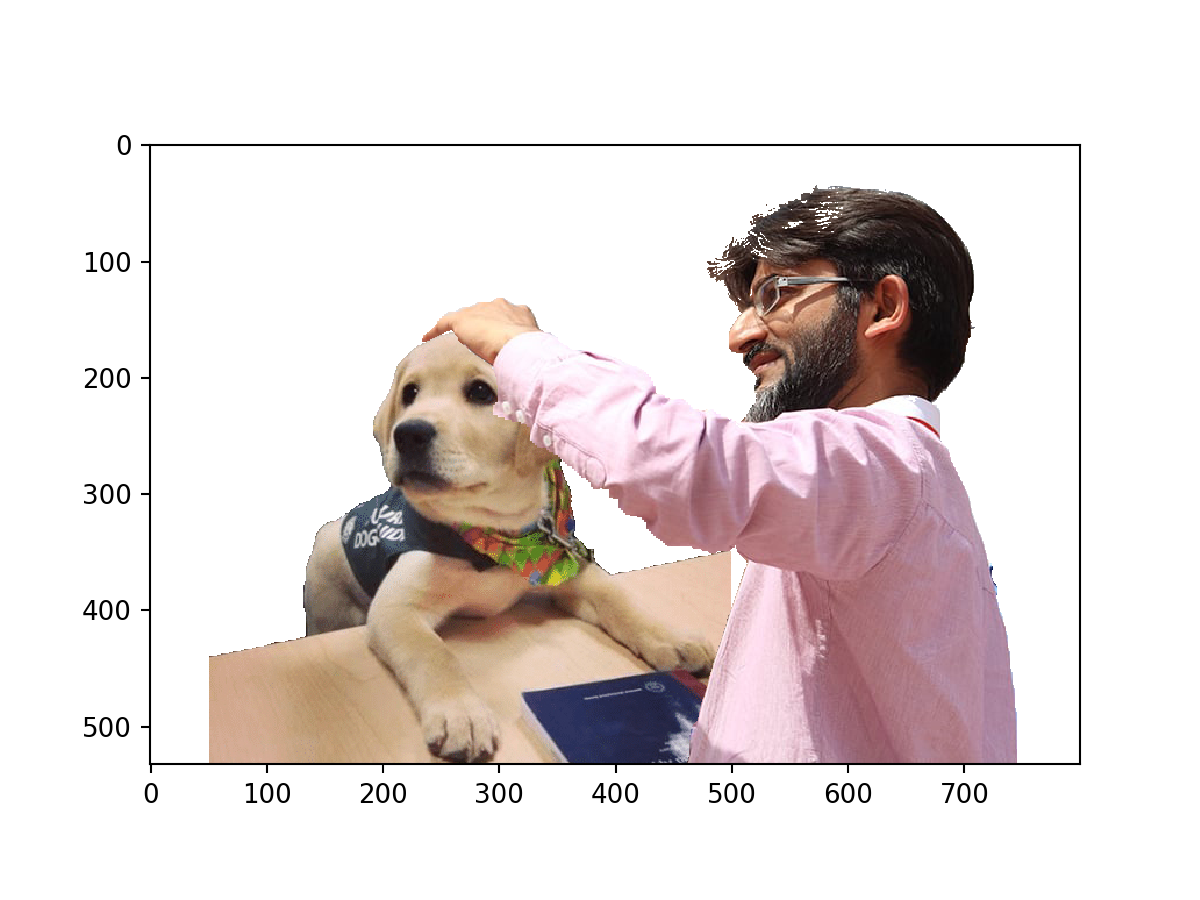

In [290]:
#TODO
#dog--> (664,500,4)
#Murtaza --> (533,800,4)

new_dog = np.zeros((dog.shape[0],dog.shape[1],4))
last = np.zeros((dog.shape[0],dog.shape[1],4))
for i in range(dog.shape[0]):
    if i+30 < dog.shape[0]:
        new_dog[i] = dog[i+30]
for i in range(dog.shape[0]):
    for j in range(dog.shape[1]):
        if j-50 > 0:
            last[i][j] = new_dog[i][j-50]

        

for i in range(bro.shape[0]):
    for j in range(new_dog.shape[1]):
        for k in range(4):
            
            if bro[i][j][k]== 0.0:
                bro[i][j][k] = last[i][j][k]
            else:
                continue

figure(dpi = 150)
plt.imshow(bro)
plt.show() 

# 2. Image Warping with OpenCV

the part you guys have been waiting for, you are finally allowed to import OpenCV and use its functions

do look at the OpenCV for python <a href="https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html">tutorials</a>. In perticular, the following will be useful for this assignment:

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#geometric-transformations

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#image-arithmetics

## Task 4.1

recreate the solution images from the previous tasks using OpenCV, in perticular the following:

- `part1/task1/cat_sol2.png`
- `part1/task2/billboard_sol.png`
- `part1/task3/dr_murtaza_sol_petting.png`
    
Why am i making you do all this again?

- Short answer: sir said so
- Long answer: it's important to learn exactly how these functions work. After going through the previous steps, you will have a better understanding of what these functions are and their limitations.

In [3]:
import cv2
import numpy as np

cat = cv2.imread('part1/task1/cat.jpg',cv2.IMREAD_COLOR)

# img = cat[0:157,85:199] # [row, columns]
# rows,cols = img.shape

# M = np.float32([[1,0,100],[0,1,50]])
# dst = cv2.warpAffine(img,M,(cols,rows))

# figure(dpi = 150)
# plt.imshow(cat)
# plt.show() 

cv2.imshow('img',cat)
cv2.waitKey(0)
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'cv2'

## Task 4.2. Another Cat Billboard

- From `part2/task4/cat_again.png` and `part2/task4/billboard.jpg`, create `part2/task4/billboard_sol.jpg`
- Be careful of file types
- You will find the functions `cv2.getPerspectiveTransform(pts1,pts2)`, `cv2.warpPerspective(img,M,(row,col))` useful
    
__cat_again.png__
<img src="part2/task4/cat_again.png" alt="cat_again.png" title="cat_again.png" />

__billboard.jpg__
<img src="part2/task4/billboard.jpg" alt="billboard.jpg" title="billboard.jpg" />

__billboard_sol.jpg__
<img src="part2/task4/billboard_sol.jpg" alt="billboard_sol.jpg" title="billboard_sol.jpg" />

In [44]:
#TODO
cat_again = np.array(cv2.imread('part2/task4/cat_again.png'))
billboard_again = np.array(cv2.imread('part2/task4/billboard.jpg'))